Load and pre process **data**

In [33]:
import os
import zipfile
from google.colab import drive

# 📌 Step 1: Mount Google Drive
drive.mount('/content/drive')

# 📌 Step 2: Define Paths
animals_zip_path = "/content/drive/MyDrive/animals10.zip"  # Training + validation (90%)
holdout_zip_path = "/content/drive/MyDrive/holdout.zip"  # Holdout set (10%)

animals_extract_to = "/content/Animals-10/"
holdout_extract_to = "/content/Holdout-10/"

# 📌 Step 3: Extract the ZIP Files
if not os.path.exists(animals_extract_to):
    with zipfile.ZipFile(animals_zip_path, 'r') as zip_ref:
        zip_ref.extractall(animals_extract_to)
    print("✅ Extracted training dataset.")

if not os.path.exists(holdout_extract_to):
    with zipfile.ZipFile(holdout_zip_path, 'r') as zip_ref:
        zip_ref.extractall(holdout_extract_to)
    print("✅ Extracted holdout dataset.")

# 📌 Step 4: Fix Dataset Paths (Point to `raw-img/`)
animals_dataset_path = "/content/Animals-10/animals10/raw-img/"
holdout_dataset_path = "/content/Holdout-10/holdout/raw-img/"

# 📌 Step 5: Check Folder Structure
print("📂 Training Dataset Categories:", os.listdir(animals_dataset_path))
print("📂 Holdout Dataset Categories:", os.listdir(holdout_dataset_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extracted training dataset.
✅ Extracted holdout dataset.
📂 Training Dataset Categories: ['sheep', 'spider', 'squirrel', 'cow', '.DS_Store', 'elephant', 'cat', 'dog', 'butterfly', 'chicken', 'horse']
📂 Holdout Dataset Categories: ['sheep', 'spider', 'squirrel', 'cow', '.DS_Store', 'elephant', 'cat', 'dog', 'butterfly', 'chicken', 'horse']


Check the folder structures

In [2]:
# List class folders
print("📂 Classes in Training Dataset:", os.listdir(animals_dataset_path))

# Print the class folders inside the holdout dataset
if os.path.exists(holdout_dataset_path):
    print("📂 Classes in Prediction (Holdout) Dataset:", os.listdir(holdout_dataset_path))
else:
    print("❌ Holdout dataset path not found:", holdout_dataset_path)


📂 Classes in Training Dataset: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']
📂 Classes in Prediction (Holdout) Dataset: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']


Normalize images, rescale and resize, train/validation split, one-hot encode is handled by imageDataGenerator

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images and apply data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,  # ✅ Increased rotation
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Load training data
train_generator = datagen.flow_from_directory(
    directory=animals_dataset_path,
    target_size=(128, 128),  # Resize images
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_generator = datagen.flow_from_directory(
    directory=animals_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("Dataset successfully loaded!")


Found 18856 images belonging to 10 classes.
Found 4709 images belonging to 10 classes.
Dataset successfully loaded!


Plot 5 random images

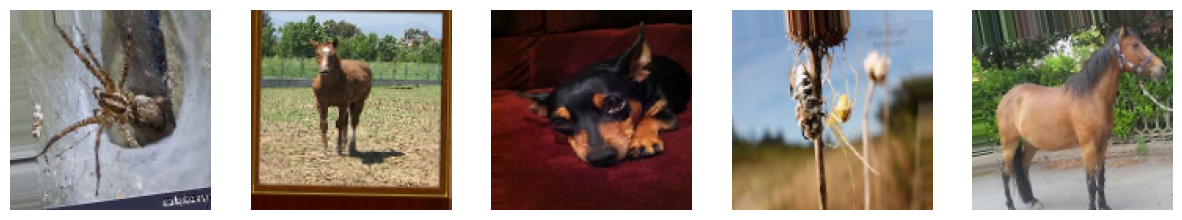

In [4]:
import matplotlib.pyplot as plt

# Get a batch of images
images, labels = next(train_generator)

# Display first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].axis("off")
plt.show()

#Define Model

In [3]:
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(512, (3,3), activation='relu'),  # New larger filter
    BatchNormalization(),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),  # ✅ Replaces Flatten()
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:

initial_learning_rate = 0.0005

model.compile(optimizer=tf.keras.optimizers.Adam(initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Fit Model

In [23]:
import time
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K

# Clear session to avoid conflicts
K.clear_session()


# Start timer
start_time = time.time()


lr_plateau = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
)
# Train model with scheduler
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    verbose=1,
    callbacks=[lr_plateau]
)

# End timer
end_time = time.time()

# Calculate total training time
training_time = end_time - start_time
print(f"⏱️ Total Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

model_name = "animal_classifier_v1.keras"  # Custom name
model.save(f"/content/{model_name}")
print(f"✅ Model saved as {model_name}")


Epoch 1/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 121s 189ms/step - accuracy: 0.3260 - loss: 2.1156 - val_accuracy: 0.4133 - val_loss: 1.7000 - learning_rate: 5.0000e-04
Epoch 2/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 173ms/step - accuracy: 0.5221 - loss: 1.4113 - val_accuracy: 0.5906 - val_loss: 1.1765 - learning_rate: 5.0000e-04
Epoch 3/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 174ms/step - accuracy: 0.5954 - loss: 1.1977 - val_accuracy: 0.6137 - val_loss: 1.1763 - learning_rate: 5.0000e-04
Epoch 4/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 173ms/step - accuracy: 0.6489 - loss: 1.0640 - val_accuracy: 0.6413 - val_loss: 1.0563 - learning_rate: 5.0000e-04
Epoch 5/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 172ms/step - accuracy: 0.6845 - loss: 0.9487 - val_accuracy: 0.5897 - val_loss: 1.3576 - learning_rate: 5.0000e-04
Epoch 6/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 173ms/step - accuracy: 0.7095 - loss: 0.8737 - val_accuracy: 0.6940 - val_loss: 0.9328 - learning_rate: 5.0000e-04
Epoch 7/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 

# Evaluate Model Performance on Validation Set (NOT on Holdout)

148/148 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.8495 - loss: 0.5316
Validation Accuracy: 85.58%
Validation Loss: 0.4896
Training Accuracy: 91.04%
Training Loss: 0.2650


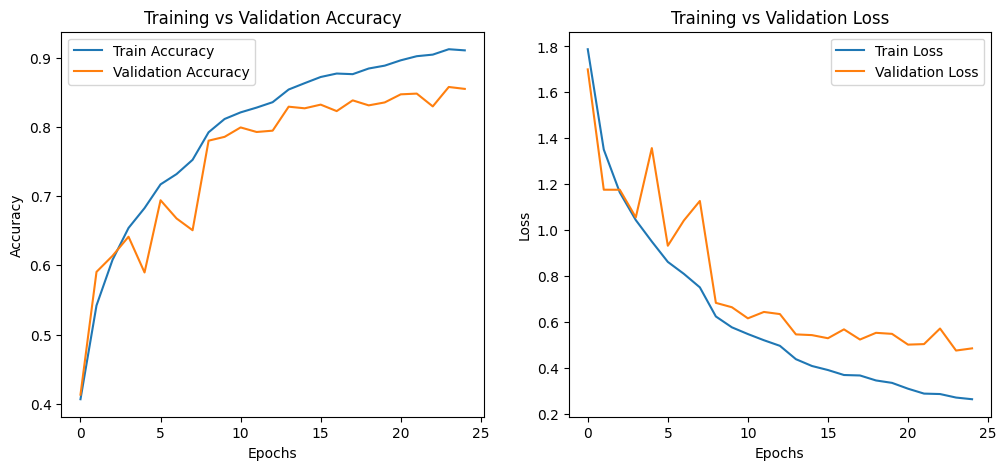

In [24]:
# 📌 Step 10: Evaluate the Model
loss, accuracy = model.evaluate(val_generator)

print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

# Get final training accuracy & loss
train_accuracy = history.history['accuracy'][-1]  # Last epoch's accuracy
train_loss = history.history['loss'][-1]  # Last epoch's loss

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# 📌 Step 11: Plot Accuracy & Loss Curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

plt.show()

# Predict on validation set

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predicted labels
y_true = []
y_pred = []

# Get class labels from the train generator
class_labels = list(train_generator.class_indices.keys())

# Predict on the entire validation set
for images, labels in val_generator:
    predictions = model.predict(images, verbose=0)  # Get model predictions
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot encoding to label index
    y_pred.extend(np.argmax(predictions, axis=1))  # Get highest probability class

    if len(y_true) >= val_generator.samples:  # Stop when all validation images are processed
        break

# 📊 Compute Precision, Recall, and F1-Score
report = classification_report(y_true, y_pred, target_names=class_labels)

# Display the report
print("📊 Classification Report:\n")
print(report)


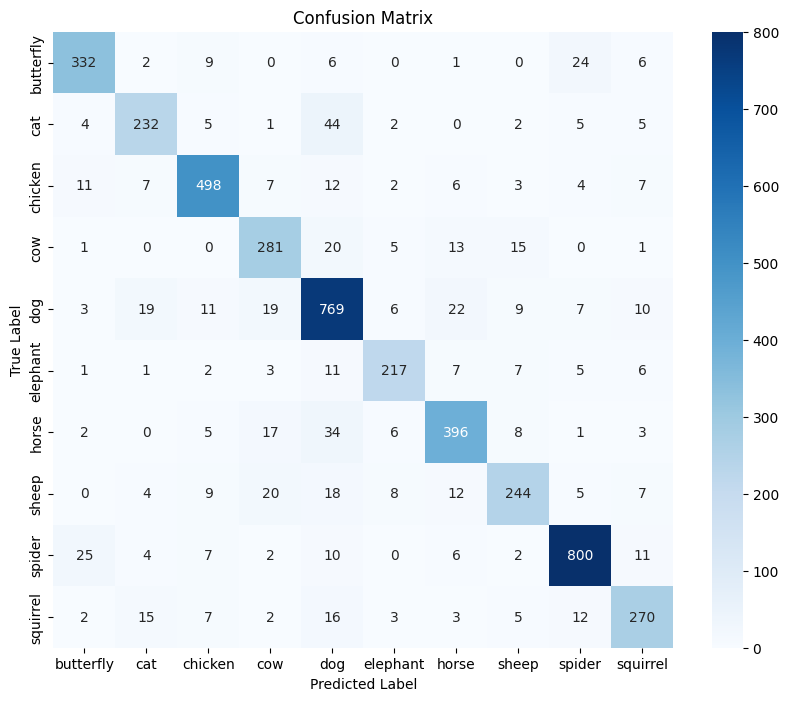

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


The model is on github. Upload it to Google Colab.
---



In [47]:
from tensorflow.keras.models import load_model

# Define the model path
model_path = "/content/animal_classifier_v2.keras"

# Load the model
model = load_model(model_path, safe_mode=False)
print("✅ Model loaded successfully!")

# Display model architecture
model.summary()


✅ Model loaded successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,115,360 (19.51 MB)

 Trainable params: 1,704,458 (6.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 3,408,918 (13.00 MB)

## Predict on Holdout Set

This predicts class for all images in the holdout folder. You can choose to predict for a smaller data set. Use the holdout_subset.zip file from github.
Load and extract the zip file, then change holdout_dataset_path below to the new path.


✅ Making Predictions on Holdout Set...

✅ Accuracy on Holdout Set: 80.99%
🔢 Correct Predictions: 2117 / 2614

❌ Found 497 Misclassified Images. Displaying...


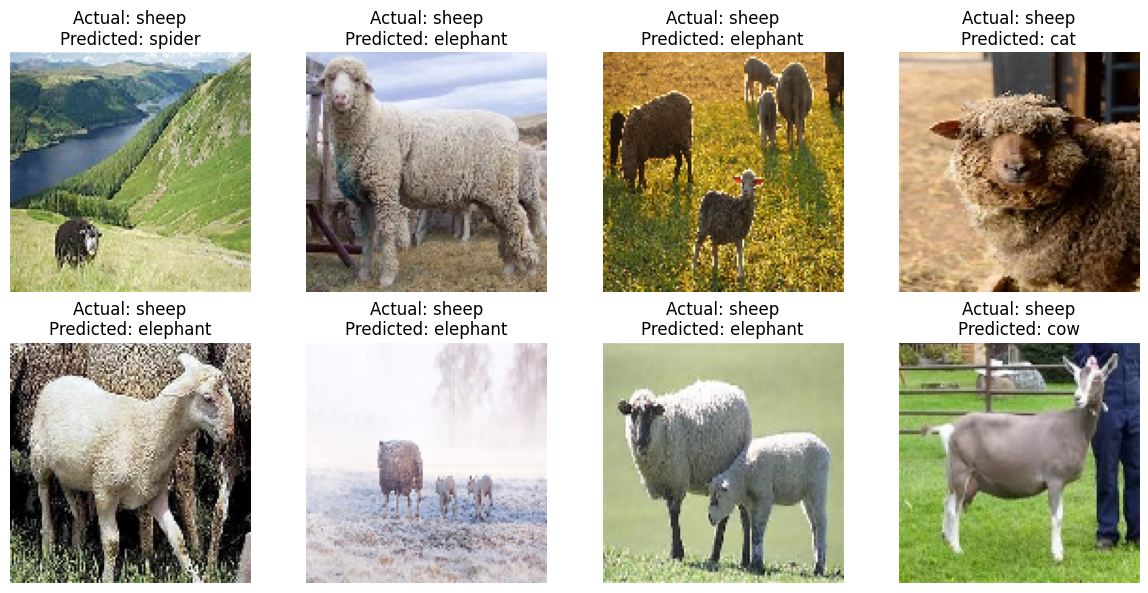

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image

print("\n✅ Making Predictions on Holdout Set...")

# Ensure class labels match the training dataset
class_labels = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

# Initialize counters
correct_predictions = 0
total_images = 0
misclassified_images = []  # Store misclassified images

for class_name in os.listdir(holdout_dataset_path):
    class_folder = os.path.join(holdout_dataset_path, class_name)

    if os.path.isdir(class_folder):
        image_files = os.listdir(class_folder)

        for img_file in image_files:  # ✅ Predict ALL images
            if img_file.endswith(('.jpg', '.png', '.jpeg')):  # Ignore `.DS_Store`
                img_path = os.path.join(class_folder, img_file)
                total_images += 1  # ✅ Count total images

                # Load & Preprocess Image
                img = image.load_img(img_path, target_size=(128, 128))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array /= 255.0  # Normalize

                # Make Prediction
                prediction = model.predict(img_array, verbose=0)
                predicted_class = np.argmax(prediction)
                predicted_label = class_labels[predicted_class]

                # Check if correct or misclassified
                if predicted_label == class_name:
                    correct_predictions += 1  # ✅ Count correct predictions
                else:
                    misclassified_images.append((img_path, class_name, predicted_label))

# 📌 Step 2: Calculate Accuracy
accuracy = (correct_predictions / total_images) * 100 if total_images > 0 else 0
print(f"\n✅ Accuracy on Holdout Set: {accuracy:.2f}%")
print(f"🔢 Correct Predictions: {correct_predictions} / {total_images}")

# 📌 Step 3: Display Misclassified Images
if misclassified_images:
    print(f"\n❌ Found {len(misclassified_images)} Misclassified Images. Displaying...")

    plt.figure(figsize=(12, 6))
    for i, (img_path, actual, predicted) in enumerate(misclassified_images[:8]):  # Show first 8 misclassified images
        img = image.load_img(img_path, target_size=(128, 128))
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")

    plt.tight_layout()
    plt.show()
else:
    print("✅ No misclassified images found in the first few samples!")
